## change the model here

In [1]:
model_name = "o1-2024-12-17"
model_provider = "openai"

### anywhere below, the most problematic part is reconsider_with_monocle prompting and output
### so if you meet any error in running, just re-run everything

In [6]:
import numpy
from py_monocle import (
    learn_graph,
    order_cells,
    compute_cell_states,
    regression_analysis,
    differential_expression_genes,
)
import os
import h5py
import scanpy as sc
from scipy import sparse

/Users/gaoyiming/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
import numpy as np
# Load data and reconstruct objects
with h5py.File("uploads/traj2_processed.h5", "r") as f:
    umap = f["UMAP"][()]
    louvain = f["Louvain"][()]
    barcodes = [bc.decode() for bc in f["expression_matrix/barcodes"]]
    features = [ft.decode() for ft in f["expression_matrix/features"]]
    data = f["expression_matrix/data"][()]
    indices = f["expression_matrix/indices"][()]
    indptr = f["expression_matrix/indptr"][()]
    timepoints = np.array([tp.decode() for tp in f["timepoint"]])
# Reconstruct expression matrix
expression_matrix = sparse.csr_matrix(
    (data, indices, indptr),
    shape=(len(barcodes), len(features))
)
# Infer trajectory
projected_points, mst, centroids = learn_graph(matrix=umap, clusters=louvain)

In [4]:
# Define root cells using earliest timepoint (e.g., "E7.5")
unique_timepoints = ['E7.5', 'E8.5', 'E9.5', 'E10.5']  # e.g., 
earliest = unique_timepoints[0]
root_cells = np.where(timepoints == earliest)[0]
pseudotime = order_cells(
    umap, centroids,
    mst=mst,
    projected_points=projected_points,
    root_cells=root_cells,
)

In [ ]:
adata = sc.read_h5ad("uploads/traj2_final.h5ad")

### clustering monocle result

In [6]:
from scipy.sparse import csr_matrix
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import matplotlib.pyplot as plt

with h5py.File("uploads/traj2_processed.h5", "r") as f:
    umap = f["UMAP"][()]
    louvain = f["Louvain"][()] 
    barcodes = [bc.decode() for bc in f["expression_matrix/barcodes"]]
    features = [ft.decode() for ft in f["expression_matrix/features"]]
    data = f["expression_matrix/data"][()]
    indices = f["expression_matrix/indices"][()]
    indptr = f["expression_matrix/indptr"][()]

# Compute cluster centroids
unique_clusters = np.unique(louvain)
centroids = np.array([umap[louvain == cluster].mean(axis=0) for cluster in unique_clusters])
# Build MST between centroids
dist_mat = distance_matrix(centroids, centroids)
mst_adjacency = minimum_spanning_tree(dist_mat)
mst_csr = csr_matrix(mst_adjacency)  # Cluster-level MST
# Compute average pseudotime per cluster (assuming existing cell-level 'pseudotime')
# Replace this with your actual pseudotime array
pseudotime_cluster = np.array([pseudotime[louvain == c].mean() for c in unique_clusters])
# Assign each cell its cluster's average pseudotime for visualization
cell_pseudotime = pseudotime_cluster[louvain]

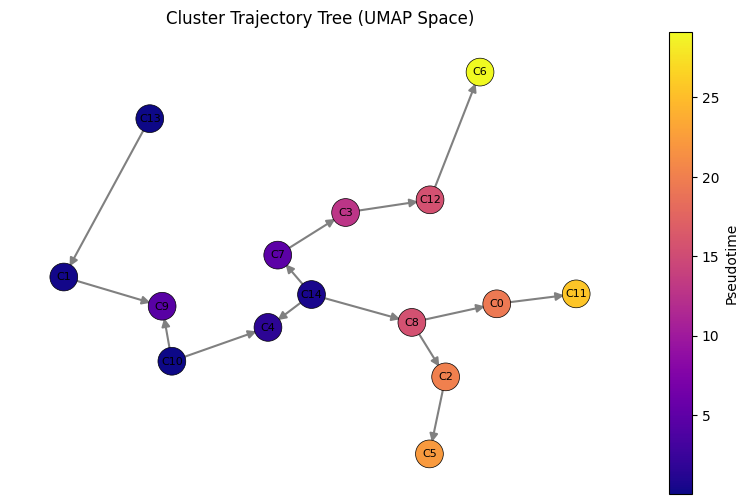

In [7]:
import networkx as nx
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
# Compute cluster-level information
unique_clusters = np.unique(louvain)
centroids = np.array([umap[louvain == cluster].mean(axis=0) for cluster in unique_clusters])
# 1. Build cluster-level MST
dist_mat = distance_matrix(centroids, centroids)
mst_adjacency = minimum_spanning_tree(dist_mat)
mst_csr = mst_adjacency.tocsr()
# 2. Get cluster edges from MST
rows, cols = mst_csr.nonzero()
cluster_edges = [(unique_clusters[i], unique_clusters[j]) for i, j in zip(rows, cols)]
# 3. Compute average pseudotime per cluster
cluster_pseudotime = {cluster: pseudotime[louvain == cluster].mean() 
                     for cluster in unique_clusters}
# Create dictionary of cluster positions
cluster_centroids = {cluster: centroids[i] 
                    for i, cluster in enumerate(unique_clusters)}
# 4. Build and direct the graph
G = nx.Graph()
for cluster in unique_clusters:
    G.add_node(cluster, pos=cluster_centroids[cluster])
G.add_edges_from(cluster_edges)
# Create directed version based on pseudotime
G_directed = nx.DiGraph()
for node in G.nodes(data=True):
    G_directed.add_node(node[0], pos=node[1]['pos'])
for edge in G.edges():
    c1, c2 = edge
    if cluster_pseudotime[c1] < cluster_pseudotime[c2]:
        G_directed.add_edge(c1, c2)
    else:
        G_directed.add_edge(c2, c1)
# 5. Visualize using UMAP coordinates
plt.figure(figsize=(10, 6))
plt.title("Cluster Trajectory Tree (UMAP Space)")
# Get positions and colors
pos = nx.get_node_attributes(G_directed, 'pos')
node_colors = [cluster_pseudotime[node] for node in G_directed.nodes()]
# Draw elements
nx.draw_networkx_nodes(
    G_directed, pos,
    node_size=400,
    node_color=node_colors,
    cmap="plasma",
    edgecolors="black",
    linewidths=0.5
)
nx.draw_networkx_edges(
    G_directed, pos,
    arrowstyle="-|>",
    arrowsize=12,
    edge_color="grey",
    width=1.5
)
nx.draw_networkx_labels(
    G_directed, pos,
    labels={cluster: f"C{cluster}" for cluster in unique_clusters},
    font_size=8
)
# Add colorbar
sm = plt.cm.ScalarMappable(cmap="plasma", 
                          norm=plt.Normalize(vmin=min(node_colors), 
                                           vmax=max(node_colors)))
sm.set_array([])
plt.colorbar(sm, label="Pseudotime", ax=plt.gca())
plt.axis("off")
plt.show()

1. On the cluster level, interpret which branch corresponds to which cell. This is more like a regular cell type annotation.

In [8]:
import json
with open("uploads/traj2_top5_dict.json", "r") as f:
    top5_dict = json.load(f)

In [9]:
percentage_df = (adata.obs.groupby("leiden")["timepoint"].value_counts(normalize=True).mul(100).unstack(fill_value=0).sort_index())
day_percentage = percentage_df.reset_index().to_dict(orient="records")
print(day_percentage)

[{'leiden': 0, 'E10.5': 11.284046692607005, 'E7.5': 0.0, 'E8.5': 63.61867704280155, 'E9.5': 25.09727626459144}, {'leiden': 1, 'E10.5': 0.0, 'E7.5': 97.8891820580475, 'E8.5': 2.1108179419525066, 'E9.5': 0.0}, {'leiden': 2, 'E10.5': 56.91943127962086, 'E7.5': 2.085308056872038, 'E8.5': 36.161137440758296, 'E9.5': 4.834123222748815}, {'leiden': 3, 'E10.5': 7.725705529306602, 'E7.5': 5.605925169199336, 'E8.5': 85.21261652407101, 'E9.5': 1.455752777423062}, {'leiden': 4, 'E10.5': 0.47318611987381703, 'E7.5': 88.17034700315457, 'E8.5': 11.198738170347003, 'E9.5': 0.15772870662460567}, {'leiden': 5, 'E10.5': 42.990904226859286, 'E7.5': 26.190476190476193, 'E8.5': 2.5949705724986623, 'E9.5': 28.223649010165865}, {'leiden': 6, 'E10.5': 98.4331797235023, 'E7.5': 0.0, 'E8.5': 0.0, 'E9.5': 1.566820276497696}, {'leiden': 7, 'E10.5': 0.15339562125226608, 'E7.5': 70.8827220750244, 'E8.5': 28.76865151303863, 'E9.5': 0.19523079068470228}, {'leiden': 8, 'E10.5': 4.421768707482993, 'E7.5': 0.0, 'E8.5': 1

/var/folders/c8/nxnh57yj7jl9f_m8v9rw47yh0000gn/T/ipykernel_90256/254422332.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_df = (adata.obs.groupby("leiden")["timepoint"].value_counts(normalize=True).mul(100).unstack(fill_value=0).sort_index())


In [10]:
context = '''
    You should understand that, this dataset is a developmental liver dataset in embryo, the time points are E7.5, 8.5, 9.5 and 10.5. We need to find the development of each celltype. They should be in developing different stages from endoderm to hepatoblasts.
'''

In [11]:
from utils.LLM import query_llm
def annotate_clusters(context,top5_dict,day_percentage,model_name,model_provider):
    query = f"""
    You are analyzing single-cell RNA-seq data. The dataset contains clusters of cells identified by Leiden clustering.
    Given these clusters and reference cell types, predict the most likely annotation for each cluster. 
    First, read the context. Then, use the top 5 genes to annotate each cluster. Finally, refine the annotation with the percentage of timepoint in each cluster, so you will know the cell type in the cluster is more likely in the proliferating or mature stage.

    Please refer to the context information of the dataset:
    {context}
    Please base your annotation on the top 5 genes of each cluster:
    {top5_dict}
    Here is the percentage of timepoint in each cluster: 
    {day_percentage}

    Remember, every cluster is a distinct cell type.

    First output your chain of thought, then provide output as a dictionary mapping cluster IDs to cell type annotations.
    For the dictionary, ONLY output a python code dictionary, do not include ```python ```.
    """
    response = query_llm(content=query, system_role="Bioinformatics LLM",model_name=model_name,model_provider=model_provider)
    return response

annotated_clusters = annotate_clusters(context=context, top5_dict=top5_dict,day_percentage=day_percentage,model_name=model_name,model_provider=model_provider)
#annotated_clusters = mapping_dict
print(annotated_clusters)

CHAIN OF THOUGHT (EXPLANATION):

1) Examine each cluster’s top 5 marker genes in the context of known developmental markers:  
   • Cardiac muscle markers (Myl4, Tnni1, Tnnt2) → likely cardiomyocytes  
   • Epithelial/endodermal markers (Krt8, Krt18, Cldn6, Cldn7) → endodermal or epithelial derivatives  
   • Liver/hepatoblast markers (Afp, Dlk1, Ttr) → hepatic lineage  
   • Endothelial markers (Cdh5/VE-cadherin, Ramp2, Egfl7, Kdr) → endothelial/hemangioblast  
   • Hematopoietic (Tal1, Lmo2, Gata1) → erythroid or early HPC  
   • Mesoderm markers (T/Brachyury, Foxf1) → mesoderm and splanchnic mesoderm  
   • Pluripotency genes (Pou5f1/Oct4, Utf1) → epiblast or primordial germ cells  
   • Extraembryonic/placental (Ifitm1, Phlda2) → extraembryonic endoderm  

2) Refine with time-point distribution to see when each cluster predominates (E7.5 earliest, E10.5 latest):  
   • Clusters heavily in E7.5 often represent very early epiblast, extraembryonic, or initial endoderm/mesoderm populat

In [12]:
import re
import ast
def extract_final_dict(text):
    # Find the last curly braces block
    matches = list(re.finditer(r'\{.*?\}', text, re.DOTALL))
    if matches:
        last_match = matches[-1].group()
        try:
            result = ast.literal_eval(last_match)
            if isinstance(result, dict):
                return result
        except Exception as e:
            print(f"Error parsing dictionary: {e}")
    return None

annotated_clusters = extract_final_dict(annotated_clusters)
annotated_clusters

{'0': 'Cardiomyocytes (developing cardiac muscle)',
 '1': 'Early endoderm (E7.5-dominant)',
 '2': 'Endothelial cells (E8.5–E10.5)',
 '3': 'Definitive endoderm (primarily E8.5)',
 '4': 'Hemangioblast / early hematopoietic-endothelial progenitors (E7.5)',
 '5': 'Erythroid lineage',
 '6': 'Maturing hepatoblasts (predominantly E10.5)',
 '7': 'Extraembryonic endoderm (E7.5)',
 '8': 'Hepatoblasts (mid-stage, mainly E9.5)',
 '9': 'Early mesoderm (E7.5–E8.5)',
 '10': 'Epiblast / early pluripotent cells (E7.5)',
 '11': 'Mesenchymal / fibroblast-like (mainly E10.5)',
 '12': 'Splanchnic mesoderm (E8.5-dominant)',
 '13': 'Primordial germ cell–like / pluripotent (100% E7.5)',
 '14': 'Foregut endoderm (hepatic–pancreatic progenitors, mainly E8.5)'}

2. Connect the stages into trajectories, that elaborate which cell type developed at which given time stage. 

In [13]:
def build_trajectory_tree(annotated_clusters, context, day_percentage,model_name=model_name,model_provider=model_provider):
    # Step 1: Ask the LLM to determine the root cluster
    root_query = f"""
    You are analyzing a single-cell RNA-seq dataset with developmental progression.
    Context: {context}

    Given the following:
    - Cell Type annotation for each cluster: {annotated_clusters}
    - Developmental stages as percentage across timepoints: {day_percentage}

    Task:
    Identify the single most appropriate root cluster for a developmental trajectory tree. 
    This should represent the developmentally earliest or least differentiated cell population.

    Only return the name of the root cluster as a string. Do not include any additional explanation.
    """
    root_cluster = query_llm(content=root_query, system_role="Bioinformatics LLM",model_name=model_name,model_provider=model_provider).strip().strip('"')
    print("the chosen root is\n",root_cluster)
    # Step 2: Build the trajectory from the root to all other clusters
    tree_query = f"""
    Construct a developmental trajectory tree starting from the root cluster: "{root_cluster}".

    Context: {context}

    Given:
    - Cell Type annotation for each cluster: {annotated_clusters}
    - Developmental stages: {day_percentage}

    Task:
    Iteratively construct a trajectory tree:
    1. The tree should begin at the root cluster: "{root_cluster}".
    2. Add directional edges from the root to other clusters based on developmental progression.
    3. Each edge should represent a biologically meaningful transition.
    4. Continue expanding the tree until all clusters are connected.
    5. Flag any biologically implausible transitions (e.g., backward differentiation).
    
    Output Format:
    Return a Python dictionary where:
      - Keys are parent nodes (clusters).
      - Values are lists of child clusters.
    Ensure every cluster appears at least once in the tree.

    In your trajectory tree, do not include any time stage, only use the Cell clusters.
    We need to set a dummy node as root (use the name "root"), and then add all cell types iteratively as leaves and leaves of leaves. DO NOT include any other node except root and cell types.
    """
    whole_tree = query_llm(content=tree_query, system_role="Bioinformatics LLM",model_name=model_name,model_provider=model_provider)

    finalize_query = f"""
    Please extract the trajectory tree inside the input. The input containing the tree is {whole_tree}
    IN YOUR REPLY, ONLY output python code tree, DO NOT include ```python ```. You can represent a tree using nested dict. DO NOT USE any square brackets. ALWAYS use nested curly brackets.

    this is the code we will use to process your output, propose your output so there is no bug triggered.
    
    try:
        return json.loads(response)
    except json.JSONDecodeError:
        pass
    # --- otherwise clean code-fence & literal_eval -----------------------
    cleaned = re.sub(r'^```[\w+-]*\n|\n```$', '', response.strip(), flags=re.S)
    try:
        return ast.literal_eval(cleaned)
    except (ValueError, SyntaxError) as e:
        raise ValueError
    
    """
    response = query_llm(content=finalize_query, system_role="You are helper to transfer text information to python dict.",model_name=model_name,model_provider=model_provider)
    try:
        return json.loads(response)
    except json.JSONDecodeError:
        pass
    # --- otherwise clean code-fence & literal_eval -----------------------
    cleaned = re.sub(r'^```[\w+-]*\n|\n```$', '', response.strip(), flags=re.S)
    try:
        return ast.literal_eval(cleaned)
    except (ValueError, SyntaxError) as e:
        raise ValueError(f"Could not parse trajectory_tree: {e}\n\nRaw text:\n{response}")

In [14]:
adata.obs['timepoint'] = adata.obs['timepoint'].astype("category")

trajectory_tree = build_trajectory_tree(annotated_clusters=annotated_clusters,context=context,day_percentage=day_percentage,model_name=model_name,model_provider=model_provider)       
print(trajectory_tree)

the chosen root is
 Epiblast / early pluripotent cells (E7.5)
{'root': {'Epiblast / early pluripotent cells (E7.5)': {'Primordial germ cell–like / pluripotent (100% E7.5)': {}, 'Extraembryonic endoderm (E7.5)': {}, 'Early endoderm (E7.5-dominant)': {'Definitive endoderm (primarily E8.5)': {'Foregut endoderm (hepatic–pancreatic progenitors, mainly E8.5)': {'Hepatoblasts (mid-stage, mainly E9.5)': {'Maturing hepatoblasts (predominantly E10.5)': {}}}}}, 'Hemangioblast / early hematopoietic-endothelial progenitors (E7.5)': {'Endothelial cells (E8.5–E10.5)': {}, 'Erythroid lineage': {}}, 'Early mesoderm (E7.5–E8.5)': {'Splanchnic mesoderm (E8.5-dominant)': {'Cardiomyocytes (developing cardiac muscle)': {}, 'Mesenchymal / fibroblast-like (mainly E10.5)': {}}}}}}


3. re-consider trajectory and cell type based on monocle

In [15]:
import random

def generate_negative_trajectory_report(G_directed, cluster_centroids, cluster_pseudotime, adata):
    """Generate an intentionally flawed natural language trajectory report"""
    all_clusters = list(cluster_pseudotime.keys())

    # Incorrect root cluster: pick a random one (not the real root)
    true_root = min(cluster_pseudotime, key=cluster_pseudotime.get)
    wrong_root = random.choice([c for c in all_clusters if c != true_root])

    # Scrambled pseudotime range
    pseudotime_range = (max(cluster_pseudotime.values()), min(cluster_pseudotime.values()))

    # Scrambled traversal order
    traversal_order = random.sample(all_clusters, len(all_clusters))

    # Fake terminal states: sample random clusters, not necessarily actual leaves
    wrong_leaves = random.sample(all_clusters, min(5, len(all_clusters)))

    # Generate fake edge info: randomly pair clusters and use random distances
    fake_edges = random.sample(
        [(u, v) for u in all_clusters for v in all_clusters if u != v],
        min(len(G_directed.edges()), 10)
    )
    fake_edge_distances = {
        (u, v): np.random.uniform(1.0, 10.0) for (u, v) in fake_edges
    }

    # Get cluster sizes (real)
    cluster_sizes = adata.obs['leiden'].value_counts().to_dict()

    # Construct faulty report
    report = f"""
    Cellular Differentiation Trajectory Analysis Report
    
    * System Overview *
    - Total clusters: {len(all_clusters)}
    - Pseudotime range: {pseudotime_range[0]:.2f} (early) → {pseudotime_range[1]:.2f} (late)
    - Root cluster: {wrong_root} ({cluster_sizes.get(wrong_root, 0)} cells)
    - Terminal states: {', '.join(map(str, wrong_leaves))}
    
    * Trajectory Structure *
    Developmental progression:
    {' → '.join(map(str, traversal_order))}
    
    Key Transitions:
    """ + '\n'.join(
        [f"- {u} → {v} (distance: {fake_edge_distances[(u,v)]:.2f}, cells: {cluster_sizes.get(v, 0)})" 
         for u, v in fake_edges]
    ) + "\n\n"

    return report

# Generate and save the report
trajectory_report = generate_negative_trajectory_report(G_directed, cluster_centroids, cluster_pseudotime, adata)
trajectory_report

'\n    Cellular Differentiation Trajectory Analysis Report\n    \n    * System Overview *\n    - Total clusters: 15\n    - Pseudotime range: 29.11 (early) → 0.03 (late)\n    - Root cluster: 0 (514 cells)\n    - Terminal states: 2, 5, 7, 4, 6\n    \n    * Trajectory Structure *\n    Developmental progression:\n    7 → 8 → 5 → 0 → 4 → 14 → 3 → 13 → 10 → 2 → 11 → 6 → 12 → 9 → 1\n    \n    Key Transitions:\n    - 7 → 8 (distance: 6.22, cells: 588)\n- 13 → 1 (distance: 7.97, cells: 3032)\n- 7 → 10 (distance: 9.50, cells: 2521)\n- 12 → 14 (distance: 1.33, cells: 352)\n- 4 → 11 (distance: 2.33, cells: 6170)\n- 9 → 13 (distance: 7.81, cells: 381)\n- 10 → 14 (distance: 1.75, cells: 352)\n- 1 → 12 (distance: 5.65, cells: 5436)\n- 14 → 11 (distance: 2.98, cells: 6170)\n- 13 → 0 (distance: 3.47, cells: 514)\n\n'

## new step 3 reconsider

In [16]:
def analyze_issues(trajectory_tree, context, annotated_clusters, trajectory_report,model_name=model_name,model_provider=model_provider):
    """Phase 1: Identify biological inconsistencies through LLM analysis"""
    analysis_prompt = f"""
    Analyze these components for trajectory improvement:
    1. Biological context: {context}
    2. Current trajectory: {trajectory_tree}
    3. Cluster annotations: {annotated_clusters}
    4. Analytical report: {trajectory_report}

    Identify:
    - Missing progenitor relationships
    - Cluster-cell type mismatches
    - Marker gene contradictions
    - Structural hierarchy errors
    - Root node completeness

    Output format: {{"issues": [list], "priority_actions": [list]}}
    """
    return query_llm(analysis_prompt, "scRNA sequencing data developmental stages trajectory diagnostics expert",model_name=model_name,model_provider=model_provider)

analysis = analyze_issues(trajectory_tree, context, annotated_clusters, trajectory_report,model_name=model_name,model_provider=model_provider)
analysis

'{\n  "issues": [\n    "Root cluster misassignment: the trajectory report names cluster 0 (Cardiomyocytes) as the root, yet the earliest embryonic population should be the Epiblast/E7.5 cluster (cluster 10).",\n    "Extraembryonic endoderm (cluster 7) incorrectly driving subsequent hepatic lineage: extraembryonic endoderm typically does not give rise to the definitive endoderm-derived liver fields.",\n    "Confused developmental sequence: the reported path (7 → 8 → 5 → 0 → 4 → 14 → 3 → 13 → 10 → 2 → 11 → 6 → 12 → 9 → 1) conflicts with known developmental biology (e.g., Erythroid/hemangioblast lineages and mesoderm branches are interspersed in ways that do not align with standard embryologic transitions).",\n    "Potential cluster-type mismatches: e.g., cardiomyocytes (cluster 0) appear too early in pseudotime, and definitive endoderm (cluster 3) is placed after foregut endoderm (cluster 14) in a way that skips known endodermal transitions.",\n    "Marker gene verification gap: the curr

In [17]:
import ast
def reconsider_with_monocle(analysis,trajectory_tree, context, annotated_clusters, trajectory_report,model_name=model_name,model_provider=model_provider):
    query = f"""
    Perform comprehensive validation of cell trajectory and annotations using biological context and analytical report insights.

    Requirements:
    1. Analyze {context} to identify key gene markers for cell fate determination.
    2. Validate hierarchical structure in {trajectory_tree} matches differentiation pathways.
    3. Resolve any inconsistencies in {annotated_clusters} using markers from {trajectory_report}.
    4. Ensure root node contains all initial progenitor states.
    5. Remove temporal references, focus on lineage relationships.

    Current trajectory structure:
    {trajectory_tree}

    Existing cluster annotations:
    {annotated_clusters}

    This is the analysis about how to improve: {analysis}

    No matter how you modify, you should make sure all the cell types in the final cell type annotation dict are in the final trajectory structure, and vice versa.

    Output Format requirement:
    - DO NOT use ```python``` to wrap your python code.
    - Return as string of two dictionaries: trajectory_dict and annotation_dict. 
    - Trajectory must be hierarchical dict. set a dummy node as root (use the name "root"), and then add all cell types as leaves.
    - In your trajectory, do not include any square brackets. use 'str' to contain nodes, and curly bracket to show tree trajectories. 
    - In the trajectory, Leaf node values should always be empty dictionaries (empty curly brackets)
    - Annotation dict must map ALL cluster IDs to terminal cell types.

    ONLY output the string of two dictionaries, no additional text/formatting.
    Be extra careful with the format of curly brackets in the nested dict of trajectory_dict.
    """
    response = query_llm(content=query, system_role="Bioinformatics expert with single-cell trajectory expertise",model_name=model_name,model_provider=model_provider)
    return response

response = reconsider_with_monocle(analysis,trajectory_tree, context, annotated_clusters, trajectory_report,model_name=model_name,model_provider=model_provider)
print(response)

trajectory_dict = {'root': {'Epiblast / early pluripotent cells': {'Primordial germ cell–like / pluripotent': {}, 'Extraembryonic endoderm': {}, 'Early endoderm': {'Definitive endoderm': {'Foregut endoderm (hepatic–pancreatic progenitors)': {'Hepatoblasts': {'Maturing hepatoblasts': {}}}}}, 'Hemangioblast / early hematopoietic-endothelial progenitors': {'Endothelial cells': {}, 'Erythroid lineage': {}}, 'Early mesoderm': {'Splanchnic mesoderm': {'Cardiomyocytes': {}, 'Mesenchymal / fibroblast-like': {}}}}}}
annotation_dict = {'0': 'Cardiomyocytes', '1': 'Early endoderm', '2': 'Endothelial cells', '3': 'Definitive endoderm', '4': 'Hemangioblast / early hematopoietic-endothelial progenitors', '5': 'Erythroid lineage', '6': 'Maturing hepatoblasts', '7': 'Extraembryonic endoderm', '8': 'Hepatoblasts', '9': 'Early mesoderm', '10': 'Epiblast / early pluripotent cells', '11': 'Mesenchymal / fibroblast-like', '12': 'Splanchnic mesoderm', '13': 'Primordial germ cell–like / pluripotent', '14': '

In [18]:
import ast
def final_synthesis(response,model_name=model_name,model_provider=model_provider):
    synthesis_prompt = f"""
    Current adjusted trajectory and refined annotations: {response}

    You may see it is a string containing one nested dictionary for trajectory, and one dictionary for annotation. We want to extract these dictionary from the string.

    Make sure to output the current input materials in correct format: Make sure all the cell types in the final cell type annotation dict are in the final trajectory structure, and vice versa.

    Output Format requirement:
    - DO NOT use ```python``` to wrap your python code.
    - Return as a single Python tuple with (trajectory_dict, annotation_dict)
    - Trajectory must be hierarchical dict. set a dummy node as root (use the name "root"), and then add all cell types as leaves.
    - In your trajectory, do not include any square brackets. use 'str' to contain nodes, and curly bracket to show tree trajectories. 
    - In the trajectory, Leaf node values should always be empty dictionaries (empty curly brackets)
    - Annotation dict must map ALL cluster IDs to terminal cell types

    ONLY output the Python tuple (trajectory_dict, annotation_dict), no additional text/formatting.
    """
    LLM_output = query_llm(synthesis_prompt, "Sring to Dict convertor",model_name=model_name,model_provider=model_provider)
    return LLM_output

final_output = final_synthesis(response,model_name=model_name,model_provider=model_provider)
final_output

"(\n{\n'root': {\n'Epiplast / early pluripotent cells': {\n'Primordial germ cell–like / pluripotent': {},\n'Extraembryonic endoderm': {},\n'Early endoderm': {\n'Definitive endoderm': {\n'Foregut endoderm (hepatic–pancreatic progenitors)': {\n'Hepatoblasts': {\n'Maturing hepatoblasts': {}\n}\n}\n}\n},\n'Hemangioblast / early hematopoietic-endothelial progenitors': {\n'Endothelial cells': {},\n'Erythroid lineage': {}\n},\n'Early mesoderm': {\n'Splanchnic mesoderm': {\n'Cardiomyocytes': {},\n'Mesenchymal / fibroblast-like': {}\n}\n}\n}\n}\n},\n{\n'0': 'Cardiomyocytes',\n'1': 'Early endoderm',\n'2': 'Endothelial cells',\n'3': 'Definitive endoderm',\n'4': 'Hemangioblast / early hematopoietic-endothelial progenitors',\n'5': 'Erythroid lineage',\n'6': 'Maturing hepatoblasts',\n'7': 'Extraembryonic endoderm',\n'8': 'Hepatoblasts',\n'9': 'Early mesoderm',\n'10': 'Epiblast / early pluripotent cells',\n'11': 'Mesenchymal / fibroblast-like',\n'12': 'Splanchnic mesoderm',\n'13': 'Primordial germ ce

In [19]:
monocled_finalized_traj, monocled_finalized_ann = ast.literal_eval(final_output)

In [20]:
adata.obs['monocled_finalized'] = adata.obs['leiden'].map(monocled_finalized_ann)
adata.obs['monocled_finalized'] = adata.obs['monocled_finalized'].astype("category")

In [2]:
monocled_finalized_traj = {'root': {'Epiblast-like cells': {'Early definitive endoderm': {'Foregut endoderm': {'Hepatic endoderm': {'Maturing hepatoblasts': {'Late-stage hepatoblasts': {}}}}},
   'Trophoblast-like cells': {'Primitive streak mesoderm': {'Hemato-endothelial progenitors': {'Endothelial cells': {},
     'Erythroid cells': {}},
    'Splanchnic mesoderm': {'Mesenchymal fibroblasts/stellate precursors': {},
     'Cardiomyocytes': {}},
    'Primordial germ cells': {}}}}}} 

In [3]:
monocled_finalized_ann = {'0': 'Cardiomyocytes', '1': 'Early definitive endoderm', '2': 'Endothelial cells', '3': 'Hepatic endoderm', '4': 'Hemato-endothelial progenitors', '5': 'Erythroid cells', '6': 'Late-stage hepatoblasts', '7': 'Trophoblast-like cells', '8': 'Maturing hepatoblasts', '9': 'Primitive streak mesoderm', '10': 'Epiblast-like cells', '11': 'Mesenchymal fibroblasts/stellate precursors', '12': 'Splanchnic mesoderm', '13': 'Primordial germ cells', '14': 'Foregut endoderm'}

### output trajectory

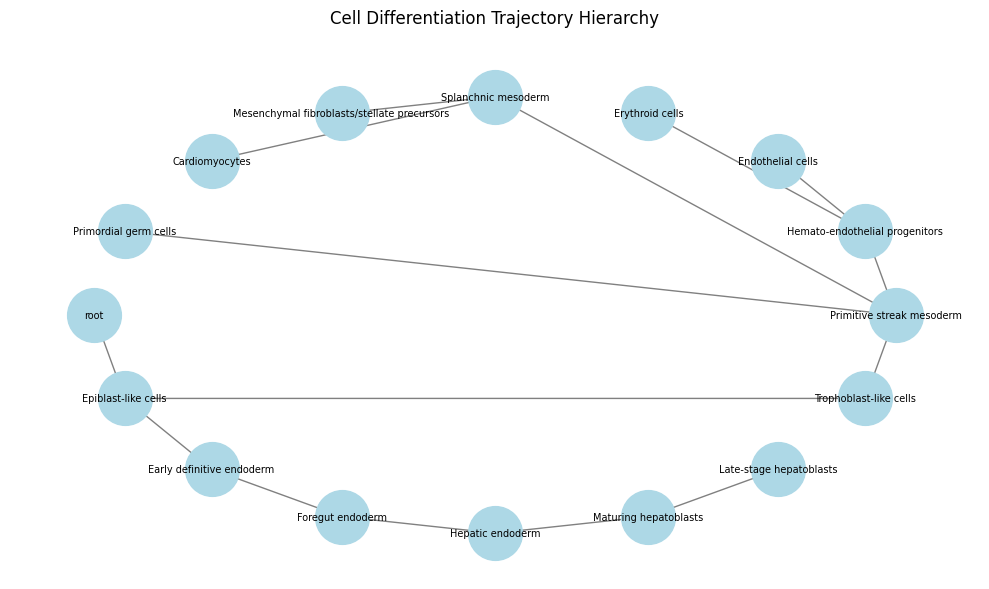

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
def build_trajectory_graph(monocled_finalized_traj):
    """Properly constructs graph from nested trajectory dictionary"""
    G = nx.DiGraph()
    G.add_node('root')
    def add_branches(parent, branches):
        for child, subtree in branches.items():
            G.add_edge(parent, child)
            if subtree:
                add_branches(child, subtree)
    add_branches('root', monocled_finalized_traj['root'])
    return G
# Create graph from trajectory tree
G = build_trajectory_graph(monocled_finalized_traj)
# Create layered layout using multipartite_layout
pos = nx.shell_layout(G)  # More organic spacing
# Fixed visualization code
plt.figure(figsize=(10, 6))
# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='lightblue')
nx.draw_networkx_edges(G, pos, edge_color='gray', arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=7)
# Extract unique y-coordinates for layers
layers = {round(pos[node][1], 2) for node in G.nodes}  # Rounded to handle float precision
# Draw horizontal lines for each layer
ax = plt.gca()
for layer in layers:
    # Find all nodes in this layer
    layer_nodes = [node for node in G.nodes if round(pos[node][1], 2) == layer]
plt.title("Cell Differentiation Trajectory Hierarchy", pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

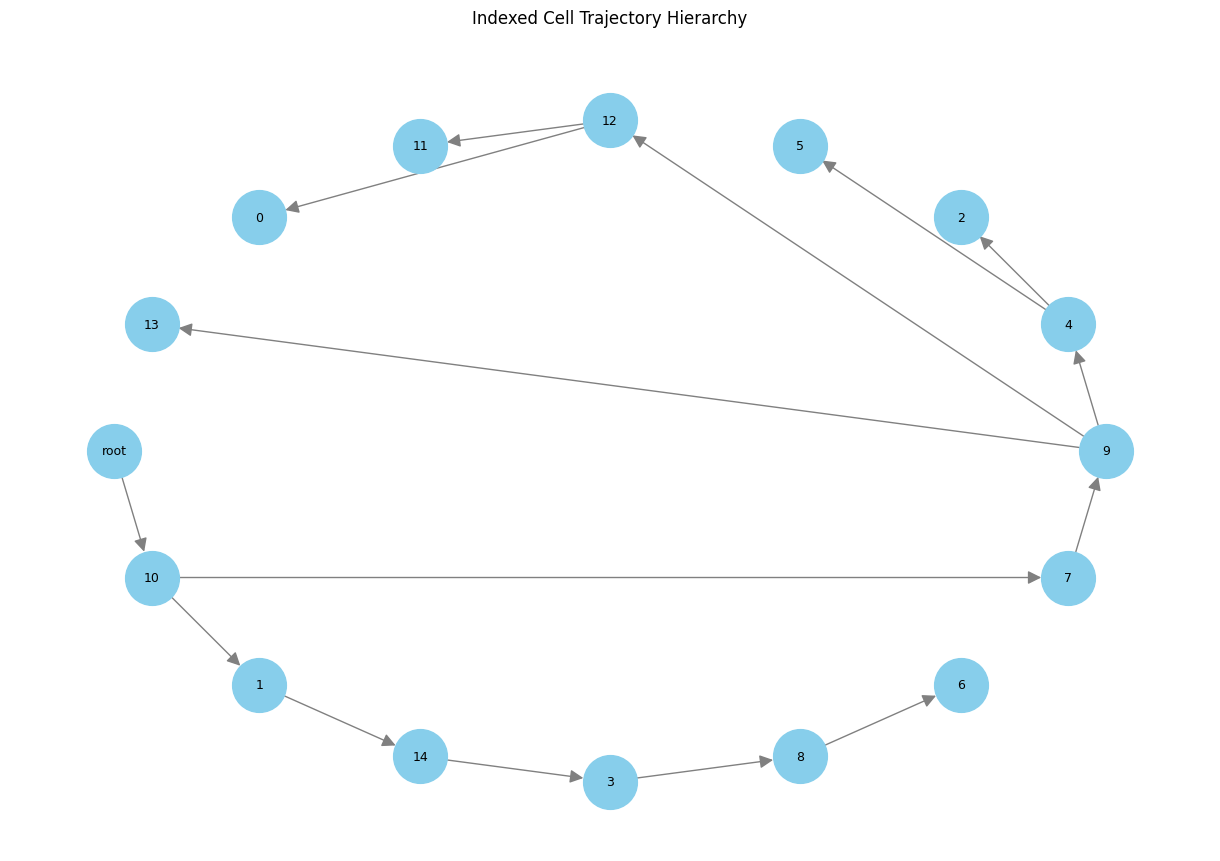

In [8]:
def build_indexed_trajectory(monocled_finalized_traj, cell_type_mapping):
    """Convert cell type names to cluster indices in trajectory tree"""
    G = nx.DiGraph()
    name_to_index = {v: k for k, v in cell_type_mapping.items()}
    # Add root node explicitly
    G.add_node('root')
    def add_indexed_branches(parent_name, subtree):
        parent_idx = name_to_index.get(parent_name, parent_name)    
        for child_name, child_subtree in subtree.items():
            child_idx = name_to_index[child_name]       
            # Add edge from parent (could be 'root' or index)
            edge_from = parent_name if parent_name == 'root' else parent_idx
            G.add_edge(edge_from, child_idx)       
            if child_subtree:
                add_indexed_branches(child_name, child_subtree)
    # Start processing from root's children
    add_indexed_branches('root', monocled_finalized_traj['root'])
    return G

cell_type_mapping = monocled_finalized_ann
G = build_indexed_trajectory(monocled_finalized_traj, cell_type_mapping)
plt.figure(figsize=(12, 8))
pos = nx.shell_layout(G, scale=1.5)
nx.draw(G, pos, 
        with_labels=True,
        node_size=1500,
        node_color='skyblue',
        edge_color='grey',
        font_size=9,
        arrowsize=20)
plt.title("Indexed Cell Trajectory Hierarchy", pad=20)
plt.show()

In [ ]:
# Step 1: Map clusters_fig3_final to leiden clusters by majority vote
# Replace adata with your actual AnnData object
import pandas as pd
ct = pd.crosstab(adata.obs["leiden"], adata.obs["Cluster"])
final_annotation = ct.idxmax(axis=1).to_dict()  # {leiden_index: cell_type_name}
cell_type_mapping_truth = {v: int(k) for k, v in final_annotation.items()}  # {cell_type: leiden_index}

import networkx as nx
import matplotlib.pyplot as plt

# ----- final_trajectory is as you defined it -----
traj_ground_truth = { ## manually annnotated 
    "root": {
        9: {
            1: {
                3: {
                    8: {
                    6: {}
                    }
                }
            }
        },
        10: {
            7: {
                4: {
                    2: {},
                    5: {}
                },
                0: {},
                12: {
                    11: {}
                }
            },
            14: {}
        },
        13: {}
    }
}

# ── Build a DiGraph where every node is an index ─────────────
def build_numeric_graph(tree):
    """Convert a nested dict trajectory to a DiGraph (nodes = ints)."""
    G = nx.DiGraph()
    G.add_node("root")
    def _add(parent, subtree):
        for child, grandchild in subtree.items():
            G.add_edge(parent, child)
            if grandchild:                 # recurse on non-leaf children
                _add(child, grandchild)

    _add("root", tree["root"])
    return G

G_ground_truth = build_numeric_graph(traj_ground_truth)

# ── Draw it (indices will be shown directly) ─────────────────
plt.figure(figsize=(12, 8))
pos = nx.shell_layout(G_ground_truth, scale=1.5)          # or nx.spring_layout(G, k=0.7)
nx.draw(
    G_ground_truth, pos,
    with_labels=True,          # prints the numeric indices
    node_size=1400,
    node_color="skyblue",
    edge_color="gray",
    arrows=True,
    arrowsize=18,
    font_size=9,
    font_weight="bold"
)
plt.title("Numeric Cluster-Index Trajectory", pad=20)
plt.axis("off")
plt.tight_layout()
plt.show()

### scoring

In [ ]:
import networkx as nx
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# -- 1. Jaccard Similarity of node sets (excluding 'root')
nodes_g = set(G.nodes) 
nodes_directed = set(G_ground_truth.nodes)

nodes_g          = {str(n) for n in nodes_g}
nodes_directed = {str(n) for n in nodes_directed}

intersection = nodes_g & nodes_directed
union = nodes_g | nodes_directed

jaccard_similarity = len(intersection) / len(union)
print(f"Jaccard Similarity (nodes): {jaccard_similarity:.4f}")

In [ ]:
import networkx as nx, time
t0 = time.time()
best = nx.graph_edit_distance(
        G, G_ground_truth,
        timeout=10,           # hard wall-clock stop
        upper_bound=None,    # cheap pruning
        roots=("root","root")           # optional: anchor known roots
)
print(best)
print(f"GED≈{best:.2f}  (computed in {time.time()-t0:.2f}s)")

In [ ]:
import ged4py as gm 
ged = gm.GraphEditDistance(1,1,1,1) 
d = ged.compare([G,G_ground_truth],None)[0,1]
d

In [ ]:
from scipy.linalg import eigvalsh

def get_sorted_laplacian_eigenvalues(graph, k=None):
    # Undirected version for Laplacian
    G_undirected = graph.to_undirected()
    L = nx.normalized_laplacian_matrix(G_undirected).toarray()
    eigenvalues = np.sort(eigvalsh(L))  # compute all eigenvalues
    if k:
        eigenvalues = eigenvalues[:k]  # top-k smallest
    return eigenvalues

# Compute eigenvalues (use top-k to match dimension if graphs are different sizes)
k = min(len(G.nodes), len(G_ground_truth.nodes))  # pick shared dimension
eigvals_g = get_sorted_laplacian_eigenvalues(G, k)
eigvals_directed = get_sorted_laplacian_eigenvalues(G_ground_truth, k)
# Euclidean distance between spectra
spectral_euclidean = np.linalg.norm(eigvals_g - eigvals_directed)
print(f"Spectral Distance (Euclidean, top-{k} eigenvalues): {spectral_euclidean:.4f}")
# Optional: Cosine similarity between spectra
spectral_cosine = cosine_similarity(eigvals_g.reshape(1, -1), eigvals_directed.reshape(1, -1))[0, 0]
print(f"Spectral Cosine Similarity (top-{k} eigenvalues): {spectral_cosine:.4f}")